Move history: NN


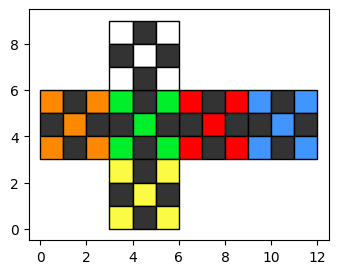